# Step 1: Brief description of the problem and data

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.

In this problem, I will be predicting whether a given tweet is about a real disaster (1) or not (0).

The training data provided in `train.csv` contains the following columns:
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - this denotes whether a tweet is about a real disaster (1) or not (0)

Since the size of the data is not mentioned in the Kaggle data description, let's do a quick check to see how many rows of data are in the `train.csv` file.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import ssl

In [1]:
file_name = "train.csv"
data = pd.read_csv(file_name)
num_rows = data.shape[0]
print(f"The number of rows in '{file_name}' is {num_rows}.")

The number of rows in 'train.csv' is 7613.


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## Step 2 Part 1: Overview
Let's take a look at some basic statistics of the data like mean, standard deviation, min, and max for numerical columns (e.g., id, target).

In [4]:
print("\nFirst 5 rows of the dataset:")
print(data.head())

print("\nSummary statistics for numerical columns:")
print(data.describe())

print("\nData types of each column:")
print(data.dtypes)

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nPercentage of missing values in each column:")
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

print("\nNumber of duplicate rows:")
duplicate_rows = data.duplicated().sum()
print(duplicate_rows)

print("\nNumber of duplicate rows based on 'text' column:")
text_duplicates = data['text'].duplicated().sum()
print(text_duplicates)

print("\nNumber of unique values in each column:")
print(data.nunique())


First 5 rows of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Summary statistics for numerical columns:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

Data types of each column:
id           int64
keyword     object
location    object
text        object


## Step 2 Part 3: `Target` Distribution
Is the distribution of the `target` column balanced?  If not, re-balancing may be needed.

Distribution of the target column:
target
0    4342
1    3271
Name: count, dtype: int64

Percentage of each target class:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


/var/folders/4s/wp81fvbx7216w_7lbpf_jmx00000gn/T/ipykernel_17660/3856086324.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='target', palette='viridis')


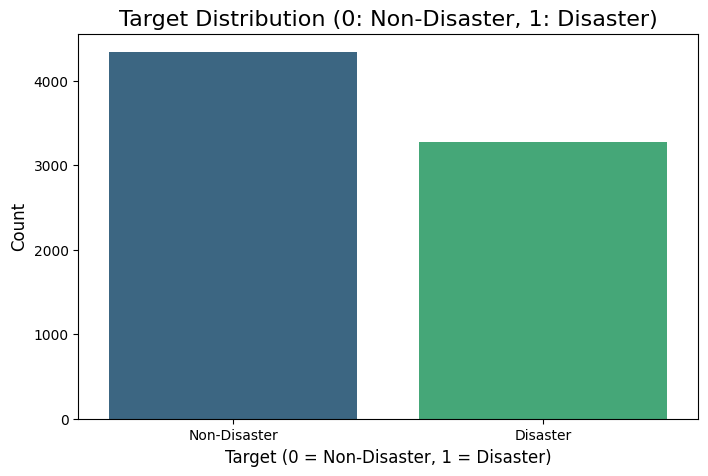

In [6]:
print("Distribution of the target column:")
print(data['target'].value_counts())

print("\nPercentage of each target class:")
target_percentage = (data['target'].value_counts(normalize=True)) * 100
print(target_percentage)

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='target', palette='viridis')
plt.title('Target Distribution (0: Non-Disaster, 1: Disaster)', fontsize=16)
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], fontsize=10)
plt.show()

## Step 2 Part 4: Text Analysis
Now let's look at text length, most common words, stopwords and special characters, the prevalence of stopwords (e.g., "the", "is"), and sentiment analysis.

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


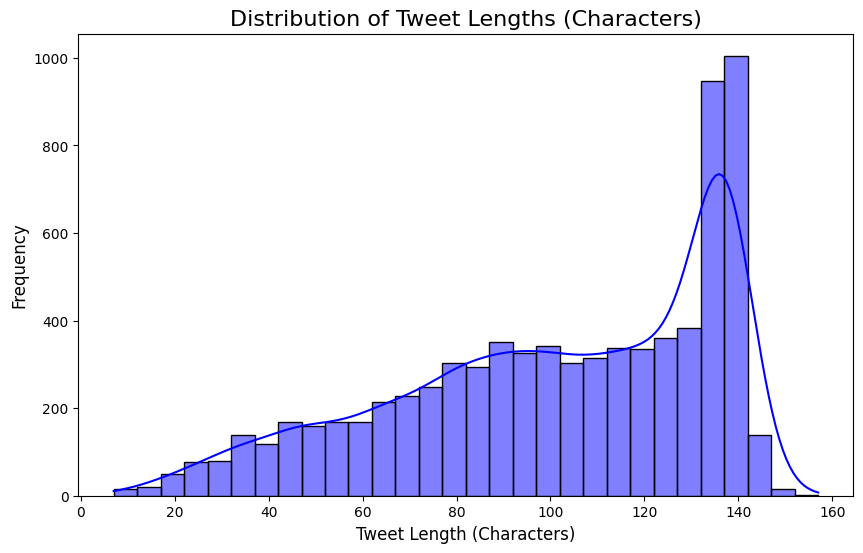

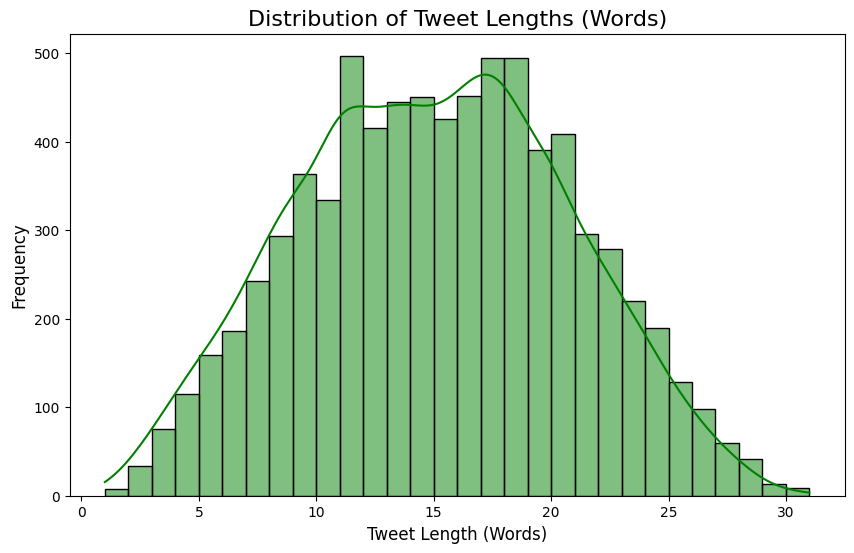

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/asnyder/nltk_data'
    - '/Users/asnyder/PycharmProjects/deep-learning-week4/.venv/nltk_data'
    - '/Users/asnyder/PycharmProjects/deep-learning-week4/.venv/share/nltk_data'
    - '/Users/asnyder/PycharmProjects/deep-learning-week4/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [11]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

# Calculate tweet lengths (number of characters and words)
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Visualize tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths (Characters)', fontsize=16)
plt.xlabel('Tweet Length (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Tweet Lengths (Words)', fontsize=16)
plt.xlabel('Tweet Length (Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Tokenize text and count word frequencies
stop_words = set(stopwords.words('english'))
all_words = [word.lower() for tweet in data['text'] for word in tweet.split() if word.lower() not in stop_words]

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Visualize most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Common Words (Excluding Stopwords)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

# Word cloud for entire dataset
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets (Excluding Stopwords)', fontsize=16)
plt.show()

# Compare most common words between target classes
disaster_words = [word.lower() for tweet in data[data['target'] == 1]['text'] for word in tweet.split() if word.lower() not in stop_words]
non_disaster_words = [word.lower() for tweet in data[data['target'] == 0]['text'] for word in tweet.split() if word.lower() not in stop_words]

disaster_counts = Counter(disaster_words).most_common(20)
non_disaster_counts = Counter(non_disaster_words).most_common(20)

# Plot disaster vs. non-disaster word frequencies
disaster_words, disaster_freq = zip(*disaster_counts)
non_disaster_words, non_disaster_freq = zip(*non_disaster_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(disaster_freq), y=list(disaster_words), color='red')
plt.title('Top 20 Words in Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(non_disaster_freq), y=list(non_disaster_words), color='blue')
plt.title('Top 20 Words in Non-Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()


## Step 2 Part 5: Keyword Analysis
Let's look at the most frequently occurring keywords, examine if specific keywords are associated with real disasters (target = 1), and analyze the correlation between keywords and the target class.


## Step 2 Part 6: Top Locations
Let's take a look at the most common location values, the location-target relationship, and missing locations.

## Step 2 Part 7: Correlations
Next I'll compare tweet lengths, word counts, and vocabulary richness between the two classes.  Then I'll look for keyword-location interaction, such as how often specific keywords appear in tweets from particular locations.


## Step 2 Conclusion
TODO: DESCRIBE INSIGHTS
Handling missing location and keyword values.
Cleaning the text column (e.g., removing URLs, mentions, hashtags, and emojis).
Lowercasing text and removing punctuation.

# Step 3: Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

# Step 4: Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.



# Step 5: Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?